# Debiasing using the NSET framework

Following the ideas from Banerjee et al. (2023)

In [1]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Number of study units
n = 1000

# Generate true means (mu_i) from a Normal distribution
mu = np.random.normal(loc=0, scale=2, size=n)

# Generate known variances (sigma_i^2) from a uniform distribution
sigma2 = np.random.uniform(low=0.5, high=1.5, size=n)

# Simulate observed Y_i ~ N(mu_i, sigma_i^2)
Y = np.random.normal(loc=mu, scale=np.sqrt(sigma2))

# Create a DataFrame to inspect
df = pd.DataFrame({
    'mu_i': mu,
    'sigma2_i': sigma2,
    'Y_i': Y
})

df.head(10)


,mu_i,sigma2_i,Y_i
0,0.993428,0.667483,0.740806
1,-0.276529,0.604568,-0.861360
2,1.295377,1.136430,1.635628
3,3.046060,1.206476,4.518406
4,-0.468307,0.531586,-1.835494
5,-0.468274,1.436212,-0.330424
6,3.158426,0.551971,3.039455
7,1.534869,1.041296,2.219931
8,-0.938949,1.209061,-0.704524
9,1.085120,1.370969,0.204651


In [2]:
# Step 2: Form (y_i, tau_i) and compute Omega

# Extract y_i (mu_i) and compute tau_i = 1/sigma2_i
y = df['mu_i'].values
tau = 1.0 / df['sigma2_i'].values

# Stack into z array and create DataFrame for inspection
z = np.column_stack((y, tau))
z_df = pd.DataFrame(z, columns=['y', 'tau'])

# Display first few rows of z
z_df.head(10)

,y,tau
0,0.993428,1.498166
1,-0.276529,1.654074
2,1.295377,0.879948
3,3.046060,0.828860
4,-0.468307,1.881163
5,-0.468274,0.696276
6,3.158426,1.811688
7,1.534869,0.960341
8,-0.938949,0.827088
9,1.085120,0.729411


In [3]:
# Compute sample covariance of z (columns as variables)
cov_z = np.cov(z, rowvar=False)

# Invert covariance to get Omega
Omega = np.linalg.inv(cov_z)
Omega_df = pd.DataFrame(Omega, index=['y', 'tau'], columns=['y', 'tau'])

# Display Omega
Omega_df


,y,tau
y,0.260853,0.031648
tau,0.031648,7.868590


In [4]:
# Assuming z (n x 2 array) and Omega are available from previous steps
n = z.shape[0]

# Compute pairwise Mahalanobis squared distances d2[i,j]
diff = z[:, None, :] - z[None, :, :]  # shape (n, n, 2)
d2 = np.einsum('ijk,kl,ijl->ij', diff, Omega, diff)

# Bandwidth selection: lambda^2 = median of non-zero d2 entries
triu_idx = np.triu_indices(n, k=1)
lambda2 = np.median(d2[triu_idx])
lambda_val = np.sqrt(lambda2)

# Compute RBF kernel matrix K
K = np.exp(-0.5 * d2 / lambda2)

# Compute gradient matrix ∇K (n x 2)
grad = np.zeros_like(z)
for i in range(n):
    dif = z[i] - z  # shape (n, 2)
    Om_dif = Omega @ dif.T  # shape (2, n)
    grad[i] = -1 / lambda2 * (Om_dif * K[i]).sum(axis=1)

# Display results
grad_df = pd.DataFrame(grad, columns=['grad_y', 'grad_tau'])
print("Bandwidth and ∇K", pd.DataFrame({
    'lambda': [lambda_val]
}))
print("First 10 rows of ∇K", grad_df.head(10))


Bandwidth and ∇K      lambda
0  1.673908
First 10 rows of ∇K        grad_y    grad_tau
0  -41.136855 -514.266598
1    7.137353 -590.277240
2  -58.782997  221.236268
3 -105.971283  217.541432
4    9.431318 -578.359869
5   23.554702  482.716173
6  -63.892381 -423.117711
7  -70.148240  102.820686
8   45.971723  315.316015
9  -45.328863  422.785374


In [5]:
# Solve for W using the score-matching equation: K W + grad = 0  => W = -K^{-1} grad
W = -np.linalg.solve(K, grad)

# Extract the first column as w1 estimates
w1_hat = W[:, 0]

# Compute NEST-corrected means: mu_hat = mu_i + sigma2_i * w1_hat
mu_hat = df['mu_i'].values + df['sigma2_i'].values * w1_hat

# Create DataFrame to inspect
results_df = pd.DataFrame({
    'mu_i': df['mu_i'],
    'sigma2_i': df['sigma2_i'],
    'w1_hat': w1_hat,
    'mu_hat_NEST': mu_hat
})

# Display first 10 rows
print("Score Estimates and NEST-corrected Means (first 10 rows)", results_df.head(10))

Score Estimates and NEST-corrected Means (first 10 rows)        mu_i  sigma2_i         w1_hat    mu_hat_NEST
0  0.993428  0.667483  264733.682513  176706.115443
1 -0.276529  0.604568  -48724.551282  -29457.573268
2  1.295377  1.136430  207193.863862  235462.669789
3  3.046060  1.206476    -206.066600    -245.568291
4 -0.468307  0.531586   78379.959808   41665.232359
5 -0.468274  1.436212  144045.612685  206879.604682
6  3.158426  0.551971   -9541.860571   -5263.674602
7  1.534869  1.041296 -123200.639998 -128286.840068
8 -0.938949  1.209061   56388.475686   68176.140755
9  1.085120  1.370969  109175.409241  149677.200261


In [6]:
# Assuming df, Y (true Y_i), and mu_hat (NEST estimates) are in the environment

# Select subset S: top 10 units by observed mu_i
k = 10
S_idx = np.argsort(df['Y_i'].values)[-k:]

# Compute true subset mean (of true Y_i)
true_mean_S = Y[S_idx].mean()

# Compute naive and NEST estimates for the subset mean
naive_est_S = df['mu_i'].values[S_idx].mean()
nest_est_S = mu_hat[S_idx].mean()

# Compile results into a DataFrame
bias_df = pd.DataFrame({
    'Estimator': ['Naive (mean of mu_i)', 'NEST (unc.)'],
    'Estimate': [naive_est_S, nest_est_S],
    'True Mean': [true_mean_S, true_mean_S],
    'Bias': [naive_est_S - true_mean_S, nest_est_S - true_mean_S]
})

# Display the bias comparison
print("Subset Bias Comparison (top 10 mu_i)", bias_df)


Subset Bias Comparison (top 10 mu_i)               Estimator     Estimate  True Mean         Bias
0  Naive (mean of mu_i)     5.225273   6.433694    -1.208421
1           NEST (unc.)  2992.183696   6.433694  2985.750001


In [8]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, LinearConstraint

# Retrieve existing data
n = df.shape[0]
K_matrix = K
grad_matrix = grad

# Define m_i and kappa for constraints
m = np.full(n, 1)  # choose m_i = 5
kappa = 0.1
sigma2 = df['sigma2_i'].values
b = 0.5 * (m - 3) / sigma2 - kappa

# Objective and gradient
def objective(w):
    W = w.reshape(n, 2)
    obj0 = W[:, 0] @ (K_matrix @ W[:, 0]) + 2 * grad_matrix[:, 0] @ W[:, 0]
    obj1 = W[:, 1] @ (K_matrix @ W[:, 1]) + 2 * grad_matrix[:, 1] @ W[:, 1]
    return obj0 + obj1

def grad_obj(w):
    W = w.reshape(n, 2)
    grad0 = 2 * (K_matrix @ W[:, 0] + grad_matrix[:, 0])
    grad1 = 2 * (K_matrix @ W[:, 1] + grad_matrix[:, 1])
    return np.concatenate([grad0, grad1])

# Linear constraints
# Inequality: W[:,1] <= b  => select second column entries
A_ub = np.zeros((n, 2*n))
for i in range(n):
    A_ub[i, n + i] = 1
ineq_constraint = LinearConstraint(A_ub, -np.inf, b)

# Equalities: sum(W[:,0]) = 0 and sum(W[:,1]) = 0
A_eq = np.zeros((2, 2*n))
A_eq[0, :n] = 1
A_eq[1, n:] = 1
eq_constraint = LinearConstraint(A_eq, [0, 0], [0, 0])

# Initial guess
w0 = np.zeros(2*n)

# Solve QP
res = minimize(objective, w0, jac=grad_obj,
               constraints=[ineq_constraint, eq_constraint],
               method='trust-constr',
               options={'maxiter': 1000, 'gtol': 1e-6})

# Extract W and compute NEST-corrected means
W_opt = res.x.reshape(n, 2)
w1_opt = W_opt[:, 0]
mu_hat_constrained = df['mu_i'].values + sigma2 * w1_opt

# Compare subset bias for top 10 mu_i
k = 100
S_idx = np.argsort(df['Y_i'].values)[-k:]
true_mean_S = Y[S_idx].mean()
naive_est_S = df['mu_i'].values[S_idx].mean()
nest_est_S_constrained = mu_hat_constrained[S_idx].mean()

# Prepare results DataFrame
bias_df2 = pd.DataFrame({
    'Estimator': ['Naive (mean of mu_i)', 'NEST (constrained)'],
    'Estimate': [naive_est_S, nest_est_S_constrained],
    'True Mean': [true_mean_S, true_mean_S],
    'Bias': [naive_est_S - true_mean_S, nest_est_S_constrained - true_mean_S]
})

# Display the comparison
print("Subset Bias Comparison with Constrained NEST")
bias_df2


Subset Bias Comparison with Constrained NEST


,Estimator,Estimate,True Mean,Bias
0,Naive (mean of mu_i),3.289724,4.157223,-0.867499
1,NEST (constrained),3.017762,4.157223,-1.139461


---

---

---

In [13]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import pdist, squareform

# Input: predictions a_hat, variances eps_hat_sq
def estimate_score(a_hat, eps_hat_sq):
    n = len(a_hat)
    
    # Bandwidth: median pairwise distance
    pairwise_dists = squareform(pdist(a_hat.reshape(-1, 1)))
    lambda_ = np.median(pairwise_dists[pairwise_dists > 0])
    
    # Kernel matrix and its gradient
    K = rbf_kernel(a_hat.reshape(-1, 1), gamma=1/(2*lambda_**2))
    grad_K = - (a_hat[:, None] - a_hat[None, :]) / lambda_**2 * K
    
    # Solve w = -K^{-1} grad_K column means
    w = -np.linalg.solve(K + 1e-6*np.eye(n), grad_K.mean(axis=1))

    print(min(w), max(w))
    
    # Debiased estimates
    a_debiased = a_hat + eps_hat_sq * w
    return a_debiased

# Example usage
a_hat = df['mu_i'].values  # Model predictions
eps_hat_sq = df['sigma2_i'].values  # Known variances
a_debiased = estimate_score(a_hat, eps_hat_sq)

-0.00597209336504797 0.018775059961424666


In [12]:
a = df['Y_i'].values

large_ixs = a > 1
large_a = a[large_ixs]
large_a_hat = a_hat[large_ixs]
large_a_debiased = a_debiased[large_ixs]

print('Mean large a:', np.mean(large_a))
print('Mean large a_hat:', np.mean(large_a_hat))
print('Mean large a_debiased:', np.mean(large_a_debiased))

Mean large a: 2.557124218194336
Mean large a_hat: 1.988913324468694
Mean large a_debiased: 1.989421960878945


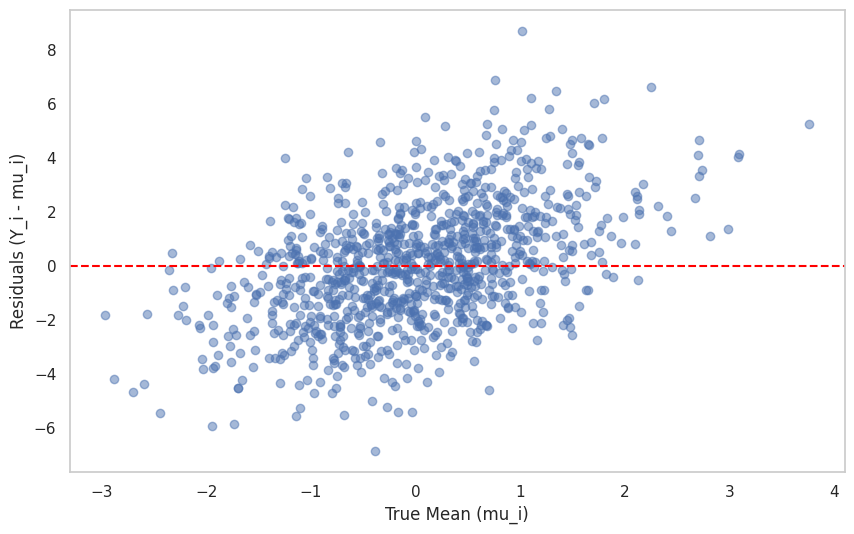

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(a_debiased - df['mu_i'], a_debiased, alpha=0.5)
plt.xlabel('True Mean (mu_i)')
plt.ylabel('Residuals (Y_i - mu_i)')
plt.axhline(0, color='red', linestyle='--')
plt.grid()
plt.show()

                  Group  Mean Income (USD)
0           CEOs (True)      177863.452757
1      CEOs (Predicted)      146221.135326
2       CEOs (Debiased)      146222.251343
3       Veterans (True)       22379.157139
4  Veterans (Predicted)       34737.330890
5   Veterans (Debiased)       34735.743731


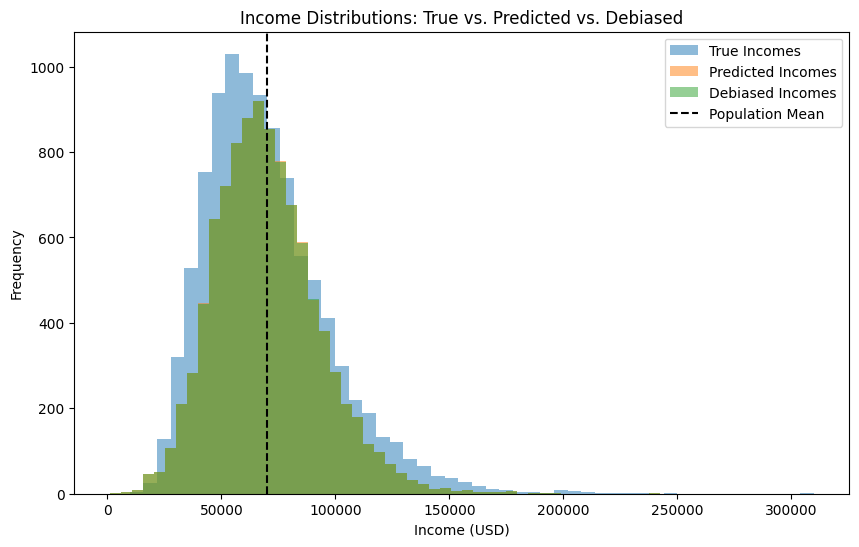

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(40)

# Parameters
n = 10_000  # Total population
mu = 70_000  # Population mean income (USD)
sigma_a = 30_000  # Std. dev. of true income
beta = 0.3  # Shrinkage factor (0 = no bias, 1 = full shrinkage to mu)
group_percentile = 0.01  # Top/bottom 1% as outlier groups

# Generate true incomes (a_i) from a log-normal distribution to mimic income skewness
true_incomes = np.random.lognormal(mean=np.log(mu), sigma=np.log(1 + sigma_a/mu), size=n)
true_incomes = true_incomes - np.mean(true_incomes) + mu  # Center at mu

# Simulate biased predictions (â_i) with regression-to-the-mean
shrinkage = beta * (true_incomes - mu)
epsilon_var = beta * (1 - beta) * np.var(true_incomes)
predicted_incomes = mu + (1 - beta) * (true_incomes - mu) + np.random.normal(0, np.sqrt(epsilon_var), n)
predicted_variances = np.full(n, epsilon_var)  # Assume homoscedasticity for simplicity

# Define outlier groups (CEOs: top 1%, Veterans: bottom 1%)
ceo_threshold = np.percentile(true_incomes, 100 - 100*group_percentile)
veteran_threshold = np.percentile(true_incomes, 100*group_percentile)

ceo_mask = true_incomes >= ceo_threshold
veteran_mask = true_incomes <= veteran_threshold

# NEST score function estimation and debiasing
def debias_predictions(a_hat, eps_hat_sq):
    n = len(a_hat)
    pairwise_dists = squareform(pdist(a_hat.reshape(-1, 1), 'euclidean'))
    lambda_ = np.median(pairwise_dists[pairwise_dists > 0])
    K = rbf_kernel(a_hat.reshape(-1, 1), gamma=1/(2*lambda_**2))
    grad_K = -(a_hat[:, None] - a_hat[None, :]) / lambda_**2 * K
    w = -np.linalg.solve(K + 1e-6*np.eye(n), grad_K.mean(axis=1))
    a_debiased = a_hat + eps_hat_sq * w
    return a_debiased

# Apply debiasing
debiased_incomes = debias_predictions(predicted_incomes, predicted_variances)

# Calculate group means
results = {
    "Group": ["CEOs (True)", "CEOs (Predicted)", "CEOs (Debiased)", 
              "Veterans (True)", "Veterans (Predicted)", "Veterans (Debiased)"],
    "Mean Income (USD)": [
        np.mean(true_incomes[ceo_mask]),
        np.mean(predicted_incomes[ceo_mask]),
        np.mean(debiased_incomes[ceo_mask]),
        np.mean(true_incomes[veteran_mask]),
        np.mean(predicted_incomes[veteran_mask]),
        np.mean(debiased_incomes[veteran_mask]),
    ]
}

# Display results
results_df = pd.DataFrame(results)
print(results_df)

# Plot distributions
plt.figure(figsize=(10, 6))
plt.hist(true_incomes, bins=50, alpha=0.5, label="True Incomes")
plt.hist(predicted_incomes, bins=50, alpha=0.5, label="Predicted Incomes")
plt.hist(debiased_incomes, bins=50, alpha=0.5, label="Debiased Incomes")
plt.axvline(mu, color="black", linestyle="--", label="Population Mean")
plt.legend()
plt.xlabel("Income (USD)")
plt.ylabel("Frequency")
plt.title("Income Distributions: True vs. Predicted vs. Debiased")
plt.show()